In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。 这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。
有时使用不同大小的卷积核组合是有利的。

In [12]:
# GoogleNet
# GoogLeNet中，基本的卷积块被称为Inception块（Inception block）
# Inception块由四条并行路径组成
class Inception(nn.Module):
    """ Google Net Inception block """
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        # c1-c4 是每条路径的输出通道数
        super(Inception, self).__init__(**kwargs)
        # 路径1：单纯的1*1卷积层
        self.path1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 路径2：1*1卷积层 + 3*3卷积层
        self.path2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.path2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 路径3：1*1卷积层 + 5*5卷积层
        self.path3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.path3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 路径4：3*3最大汇聚层后接1*1卷积层
        self.path4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.path4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        
    def forward(self, x):
        p1 = F.relu(self.path1_1(x))
        p2 = F.relu(self.path2_2(F.relu(self.path2_1(x))))
        p3 = F.relu(self.path3_2(F.relu(self.path3_1(x))))
        p4 = F.relu(self.path4_2(self.path4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)
    

In [13]:
# Goognet的其他模块
block1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
) 

block2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

block3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

block4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

block5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
)

net = nn.Sequential(block1, block2, block3, block4, block5, nn.Linear(1024, 10))

In [14]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.243, train acc 0.907, test acc 0.898
1846.2 examples/sec on cuda:0


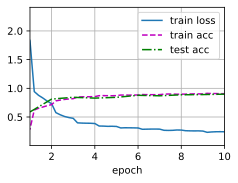

In [15]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

由于在训练过程中，中间层的变化幅度不能过于剧烈，而批量规范化(BN)将每一层主动居中，并将它们重新调整为给定的平均值和大小，由于批量规范化在完整的小批量上运行，因此我们不能像以前在引入其他层时那样忽略批量大小

In [20]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    """ 计算batch normalization """
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征上的均值或者方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上的（axis = 1）的均值和方法
            # 这里需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
            
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方法
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    # 缩放和移位
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [21]:
class BatchNorm(nn.Module):
    """ BN层 """
    def __init__(self, num_features, num_dims):
        """ 构造函数
        
        num_featres: 完全连接层的输出数量活卷积层的输出通道数
        num_dims：2表示完全连接层，4表示卷积层
        """
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与梯度计算和迭代的拉伸和偏移参数，分别初始化为1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape) 
        
        
    def forward(self, X):
        """ 前向推理 """
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        
        # 保存更新过的moving_mean 和 moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9,
        )
        return Y

In [22]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    BatchNorm(6, num_dims=4),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6, 16, kernel_size=5), 
    BatchNorm(16, num_dims=4), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    
    nn.Flatten(),
    nn.Linear(16*4*4, 120), 
    BatchNorm(120, num_dims=2), 
    nn.Sigmoid(),
    
    nn.Linear(120, 84), 
    BatchNorm(84, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(84, 10),
)

loss 0.269, train acc 0.901, test acc 0.859
34428.3 examples/sec on cuda:0


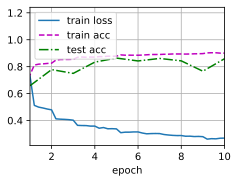

In [23]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

 残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。 于是，残差块（residual blocks）便诞生了，这个设计对如何建立深层神经网络产生了深远的影响

In [41]:
class Residual(nn.Module):  #@save
    """ ResNet 残差块实现 """
    def __init__(self, input_channels, num_channels, 
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, 
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [42]:
block= Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = block(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [43]:
block = Residual(3,6, use_1x1conv=True, strides=2)
block(X).shape

torch.Size([4, 6, 3, 3])

In [44]:
# ResNet
block1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

In [45]:
def resnet_block(input_channels, num_channels, 
                 num_residuals, first_block=False):
    block = []
    for i in range(num_residuals):
        if i == 0  and not first_block:
            block.append(Residual(input_channels, num_channels, 
                                  use_1x1conv=True, strides=2))
        else:
            block.append(Residual(num_channels, num_channels))
    return block

block2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
block3 = nn.Sequential(*resnet_block(64, 128, 2))
block4 = nn.Sequential(*resnet_block(128, 256, 2))
block5 = nn.Sequential(*resnet_block(256, 512, 2))

In [46]:
resnet = nn.Sequential(
    block1, 
    block2, 
    block3,
    block4,
    block5,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 10),
)

In [47]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in resnet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.012, train acc 0.997, test acc 0.921
2731.3 examples/sec on cuda:0


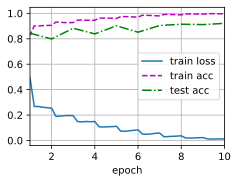

In [49]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(resnet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

DenseNet
ResNet将f分解为两部分：一个简单的线性项和一个复杂的非线性项
再向前拓展一步，如果我们想将f拓展成超过两部分的信息呢？ 一种方案便是DenseNet
稠密网络主要由2部分构成：稠密块（dense block）和过渡层（transition layer）。 前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

In [50]:
def conv_block(input_channels, num_channels):
    block = nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3,padding=1),
    )
    return block

In [53]:
class DenseBlock(nn.Module):
    """ 稠密层 """
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
        
    def forward(self, X):
        for block in self.net:
            Y = block(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

In [54]:
block = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = block(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [55]:
def transition_block(input_channels, num_channels):
    """ 过渡层 """
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [56]:
block = transition_block(23, 10)
block(Y).shape

torch.Size([4, 10, 4, 4])

In [58]:
b1ock1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blocks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blocks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blocks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2    

In [61]:
dense_net = nn.Sequential(
    block1, 
    *blocks,
    nn.BatchNorm2d(num_channels), 
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10),
)

loss 0.146, train acc 0.948, test acc 0.886
2800.5 examples/sec on cuda:0


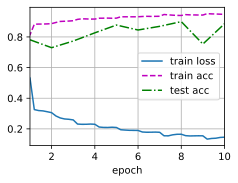

In [63]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(dense_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())